In [1]:
from typing import Optional
import matplotlib.pyplot as plt


def display_4d_array(array):
    R, C, _, _ = array.shape
    params = dict()
    for i, row in enumerate(array):
        for j, img in enumerate(row):
            params[f"{i}_{j}"] = img
    display_arrays(cols=C, rows=R, **params)


def display_arrays(rows: int = 1, cols: Optional[int] = None, **images_kwargs):
    """
    Displays multiple image arrays using Matplotlib in a grid layout.

    Args:
        rows: The number of rows in the subplot grid.
        cols: The number of columns in the subplot grid.
        **images_kwargs: Keyword arguments where each key is the title
                         and each value is a 2D numpy/jax array (image).
    """
    num_images = len(images_kwargs)
    if num_images == 0:
        print("No images provided to display.")
        return

    if cols is None:
        cols = math.ceil(num_images / rows)
    if rows * cols < num_images:
        print(
            f"Warning: Not enough subplots ({rows}x{cols}={rows * cols}) for {num_images} images. "
            f"Some images will not be displayed.")
        # Optionally, you could adjust rows/cols or raise an error

    fig, axes = plt.subplots(rows, cols, figsize=(cols * 4, rows * 4))  # Adjust figsize as needed

    # If rows=1 and cols=1, axes is not an array but a single AxesSubplot object.
    # If rows=1 or cols=1, axes is a 1D array.
    # Otherwise, axes is a 2D array.
    # We flatten it for easier iteration.
    if isinstance(axes, plt.Axes):  # Single subplot
        axes_flat = [axes]
    else:
        axes_flat = axes.flatten()

    for i, (title, img_array) in enumerate(images_kwargs.items()):
        if i >= len(axes_flat):
            break  # Stop if we run out of subplots

        ax = axes_flat[i]
        # Convert JAX array to NumPy array if it's not already, for matplotlib
        # Matplotlib usually handles JAX arrays fine, but explicit conversion is safer.
        img_to_plot = np.asarray(img_array)

        im = ax.imshow(img_to_plot, cmap='Greys', vmin=0, vmax=1)  # You can change the colormap
        ax.set_title(title)
        ax.axis('off')  # Hide axes ticks and labels

    # Hide any unused subplots
    for j in range(num_images, len(axes_flat)):
        axes_flat[j].axis('off')

    plt.tight_layout()
    plt.show()


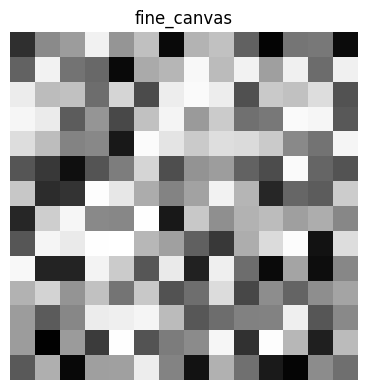

(14, 14)


In [2]:
import plotly.express as px
import jax.numpy as jnp
import jax
from flax import nnx
import random

# Example: Create a sample NumPy matrix
rngs = nnx.Rngs(12)

PATCH_COARSE_HEIGHT = 5
PATCH_COARSE_WIDTH = 5
PATCH_COARSE_SIZE = (PATCH_COARSE_HEIGHT, PATCH_COARSE_WIDTH)

UP_SAMPLE_RATIO = 2
UP_SAMPLE_SIZE = (UP_SAMPLE_RATIO, UP_SAMPLE_RATIO)

BORDER_COARSE_EXTENT = 1
BORDER_FINE_EXTENT = BORDER_COARSE_EXTENT * UP_SAMPLE_RATIO
BORDER_FINE_SIZE = (BORDER_FINE_EXTENT, BORDER_FINE_EXTENT)

PATCH_FINE_HEIGHT = PATCH_COARSE_HEIGHT * UP_SAMPLE_RATIO
PATCH_FINE_WIDTH = PATCH_COARSE_WIDTH * UP_SAMPLE_RATIO
PATCH_FINE_SIZE = (PATCH_FINE_HEIGHT, PATCH_FINE_WIDTH)

CANVAS_FINE_HEIGHT = PATCH_FINE_HEIGHT + 2 * BORDER_FINE_EXTENT
CANVAS_FINE_WIDTH = PATCH_FINE_WIDTH + 2 * BORDER_FINE_EXTENT
CANVAS_FINE_SIZE = (CANVAS_FINE_HEIGHT, CANVAS_FINE_WIDTH)

canvas_fine = jax.random.beta(rngs.image(), 1.0, 1.0, CANVAS_FINE_SIZE)

# matrix = np.random.rand(30, 30)

# Plot the matrix as an image using px.imshow

display_arrays(fine_canvas=canvas_fine)
print(canvas_fine.shape)


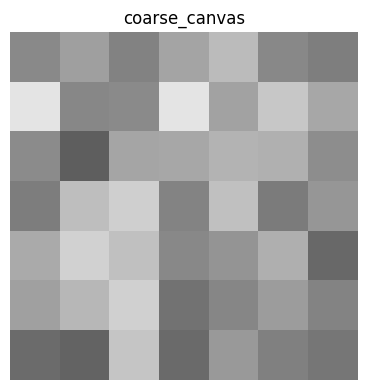

(7, 7)


In [3]:
def downsample_via_reshape(image_2d, block_shape):
    H, W = image_2d.shape
    bh, bw = block_shape
    H_new = (H // bh) * bh
    W_new = (W // bw) * bh

    if H_new != H or W_new != W:
        print(
            f"Warning: Image dimensions ({H}, {W}) not perfectly divisible by block_shape ({bh}, {bw}). Cropped to ({H_new}, {W_new}).")

    image_cropped = image_2d[:H_new, :W_new]
    reshaped = image_cropped.reshape(H_new // bh, bh, W_new // bw, bw)
    transposed = jnp.transpose(reshaped, (0, 2, 1, 3))
    downsampled = jnp.mean(transposed, axis=(2, 3))
    return downsampled


coarse_canvas = downsample_via_reshape(canvas_fine, UP_SAMPLE_SIZE)
display_arrays(coarse_canvas=coarse_canvas)
print(coarse_canvas.shape)


[1 0]
[0.5 0. ]
[1 2] [11 12]


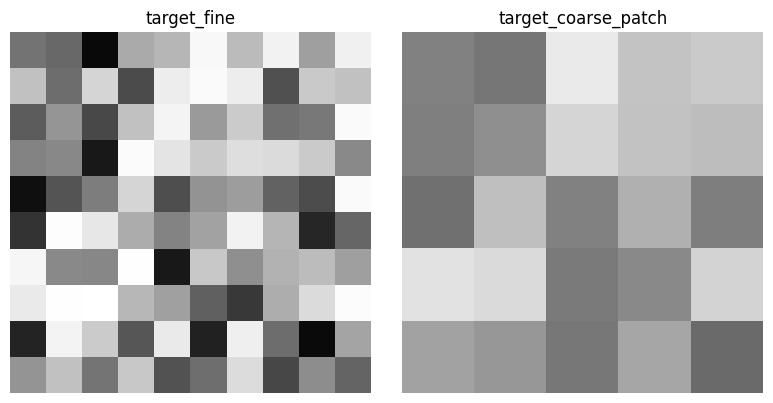

In [4]:

# target_fine_offset_int = jax.random.randint(rngs.target(), (2,), -BORDER_FINE_EXTENT,
#                                             BORDER_FINE_EXTENT)

target_fine_offset_int = jnp.array([1, 0])
print(target_fine_offset_int)
target_fine_offset_float = target_fine_offset_int / BORDER_FINE_EXTENT
print(target_fine_offset_float)


def get_shifted_patch(canvas: jax.Array, shift_int: jax.Array) -> jax.Array:
    start = jnp.array(BORDER_FINE_SIZE) - shift_int
    end = start + jnp.array(PATCH_FINE_SIZE)
    print(start, end)
    patch = canvas[start[0]:end[0], start[1]:end[1]]
    return patch


target_fine = get_shifted_patch(canvas_fine, target_fine_offset_int)
target_coarse = downsample_via_reshape(target_fine, UP_SAMPLE_SIZE)
# patch_fine = get_shifted_patch(canvas_fine, jnp.array([0, 0]))
# patch_coarse = downsample_via_reshape(patch_fine, UP_SAMPLE_SIZE)
display_arrays(target_fine=target_fine, target_coarse_patch=target_coarse)


[0.5 0. ]


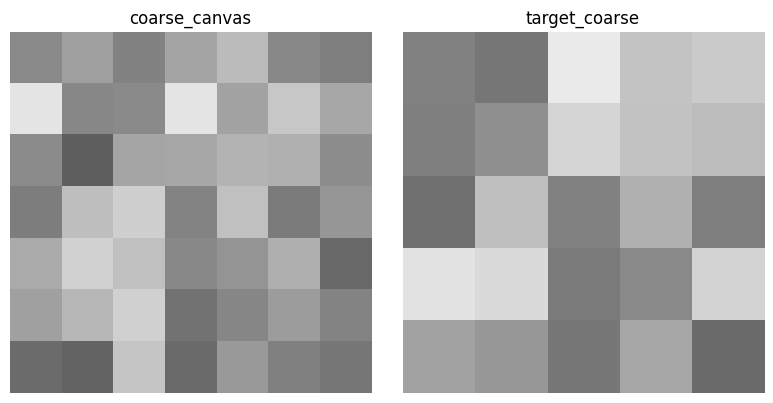

In [6]:
import math
from IPython.display import Image, display


def get_array_slice(source: jax.Array, dx: int, dy: int) -> jax.Array:
    B = BORDER_COARSE_EXTENT
    H = PATCH_COARSE_HEIGHT
    W = PATCH_COARSE_WIDTH
    return source[B + dy:B + H + dy, B + dx:B + W + dx]

    # return source[slice_array[0,0]:slice_array[1,0], slice_array[0,1]:slice_array[1,1]]


def window_0_p(source: jax.Array) -> jax.Array:
    return get_array_slice(source, 0, 1)


def window_0_n(source: jax.Array) -> jax.Array:
    return get_array_slice(source, 0, -1)


def window_p_0(source: jax.Array) -> jax.Array:
    return get_array_slice(source, 1, 0)


def window_n_0(source: jax.Array) -> jax.Array:
    return get_array_slice(source, 0, -1)


def window_p_p(source: jax.Array) -> jax.Array:
    return get_array_slice(source, 1, 1)


def window_n_n(source: jax.Array) -> jax.Array:
    return get_array_slice(source, -1, -1)


def window_p_n(source: jax.Array) -> jax.Array:
    return get_array_slice(source, 1, -1)


def window_n_p(source: jax.Array) -> jax.Array:
    return get_array_slice(source, -1, 1)


def make_4_shifted_patches(canvas: jax.Array, shifts: jax.Array) -> jax.Array:
    CH, CW = canvas.shape
    assert CH == PATCH_COARSE_HEIGHT + 2
    assert CW == PATCH_COARSE_WIDTH + 2

    s0 = get_array_slice(canvas, 0, 0)
    offset_y, offset_x = jnp.where(shifts > 0, jnp.ceil(shifts), jnp.floor(shifts)).astype(
        jnp.int32)
    sy = jax.lax.cond(offset_y > 0, window_p_0, window_n_0, canvas)
    sx = jax.lax.cond(offset_x > 0, window_0_p, window_0_n, canvas)
    sxy = jax.lax.cond(
        offset_x < 0,
        lambda s: jax.lax.cond(offset_y < 0, window_n_n, window_n_p, s),
        lambda s: jax.lax.cond(offset_y < 0, window_p_n, window_p_p, s),
        canvas
    )
    patches = [[s0, sx], [sy, sxy]]
    return jnp.array(patches)


@jax.jit
def translation_loss(canvas: jax.Array, target: jax.Array, shifts: jax.Array) -> jax.Array:
    shifted = make_4_shifted_patches(canvas, shifts)
    coarse_losses = jnp.abs(target - shifted)
    losses_sums = jnp.sum(coarse_losses, axis=(2, 3))
    dy, dx = shifts
    weights = jnp.array([
        [(1 - dy) * (1 - dx), (1 - dy) * dx],
        [dy * (1 - dx), dy * dx]
    ])
    return jnp.sum(losses_sums * weights)


# shift = jnp.array([-0.1, 0.2])
# translation_loss(coarse_canvas, patch)
# print(coarse_canvas.shape)
# print(PATCH_COARSE_WIDTH)
# shifted_patches = make_4_shifted_patches(coarse_canvas, shift)

# shift_grad = jax.grad(make_4_shifted_patches, argnums=1)
# shift_grad(coarse_canvas, shift)
shifts = jnp.array([0.9, 0.6])
shifted_patches = make_4_shifted_patches(coarse_canvas, shifts)
# display_4d_array(shifted_patches)
grad_translation_loss = jax.grad(translation_loss, argnums=2)
# translation_loss(coarse_canvas, target_coarse, jnp.array([0.5, 0.2]))
print(target_fine_offset_float)
# grad_translation_loss(coarse_canvas, target_coarse, jnp.array([-0.35, 0.375]))
#[ 0.75 -0.5 ]
# print(translation_loss(coarse_canvas, target_coarse, jnp.array([-1, 0.9])))

def iter_solve():
    aim = jnp.array([1e-5, 1e-5])
    decay = 0.99
    rate = 0.2
    for i in range(100):
        rate = rate * decay
        loss = translation_loss(coarse_canvas, target_coarse, aim)
        grad = grad_translation_loss(coarse_canvas, target_coarse, aim)
        aim_new = jnp.clip(aim - rate * grad, -1.0, 1.0)
        print(f"aim: {aim} -> (loss: {loss}, grad: {grad})\n\t rate: {rate:.3f}, aim => {aim_new}")
        aim = aim_new

translation_loss(coarse_canvas, target_coarse, jnp.array([0.99, -0.99]))
display_arrays(coarse_canvas=coarse_canvas, target_coarse=target_coarse)


In [443]:
iter_solve()

aim: [1.e-05 1.e-05] -> (loss: 2.3704864978790283, grad: [1.788659  0.8126148])
	 rate: 0.198, aim => [-0.35414445 -0.16088773]
aim: [-0.35414445 -0.16088773] -> (loss: 2.6835217475891113, grad: [-0.73807913 -1.238849  ])
	 rate: 0.196, aim => [-0.20946617  0.08195147]
aim: [-0.20946617  0.08195147] -> (loss: 2.485567092895508, grad: [-0.23159297  0.58363086])
	 rate: 0.194, aim => [-0.16452329 -0.03130782]
aim: [-0.16452329 -0.03130782] -> (loss: 2.4467055797576904, grad: [-0.40230963 -0.74749976])
	 rate: 0.192, aim => [-0.08723189  0.11230122]
aim: [-0.08723189  0.11230122] -> (loss: 2.479027032852173, grad: [-0.198414   0.7172601])
	 rate: 0.190, aim => [-0.04949394 -0.02412022]
aim: [-0.04949394 -0.02412022] -> (loss: 2.3971974849700928, grad: [-0.38368502 -0.44943377])
	 rate: 0.188, aim => [0.02275242 0.06050638]
aim: [0.02275242 0.06050638] -> (loss: 2.459030866622925, grad: [1.7317407 0.7912176])
	 rate: 0.186, aim => [-0.30006665 -0.08698692]
aim: [-0.30006665 -0.08698692] ->

In [7]:
import plotly.graph_objects as go
import jax.numpy as jnp
import numpy as np

# Ensure coarse_canvas and target_coarse are defined from previous cells.
# Also, the translation_loss function and its dependencies (make_4_shifted_patches, get_array_slice)
# and constants (BORDER_COARSE_EXTENT, PATCH_COARSE_HEIGHT, PATCH_COARSE_WIDTH)
# must be in scope.

# Define the range for dx and dy
dx_vals = np.arange(-1.0, 1.01, 0.1)  # Using 1.01 to ensure 1.0 is included
dy_vals = np.arange(-1.0, 1.01, 0.1)

# Initialize an array to store the Z values (loss)
# Z_loss_values[i, j] will store loss for dy_vals[i] and dx_vals[j]
Z_loss_values = np.zeros((len(dy_vals), len(dx_vals)))

# Calculate the loss for each combination of dx and dy
print("Calculating loss values for the 3D Plotly plot (this may take a moment)...")
for i in range(len(dy_vals)):
    for j in range(len(dx_vals)):
        dy_val = dy_vals[i]
        dx_val = dx_vals[j]
        current_shifts = jnp.array([dy_val, dx_val])
        loss = translation_loss(coarse_canvas, target_coarse, current_shifts)
        Z_loss_values[i, j] = float(loss)
print("Calculation complete.")

# Create the 3D surface plot using Plotly
# For go.Surface:
# - z is the 2D array of height values.
# - x is a 1D array corresponding to the columns of z.
# - y is a 1D array corresponding to the rows of z.
fig = go.Figure(data=[go.Surface(z=Z_loss_values, x=dx_vals, y=dy_vals, colorscale='Viridis')])

# Update layout for titles and axis labels
fig.update_layout(
    title='3D Surface Plot of Translation Loss (Plotly)',
    scene=dict(
        xaxis_title='dx (shift component)',
        yaxis_title='dy (shift component)',
        zaxis_title='Translation Loss'
    ),
    autosize=False,
    width=800,
    height=700,
    margin=dict(l=65, r=50, b=65, t=90)
)

fig.show()

Calculating loss values for the 3D Plotly plot (this may take a moment)...
Calculation complete.
